In [1]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

# File Tools for local
import pandas as pd

# Sampling
from pyDOE import lhs

In [2]:
import torch
from botorch.models import SingleTaskGP
from botorch.models import MixedSingleTaskGP

from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import qUpperConfidenceBound
from botorch.acquisition.active_learning import qNegIntegratedPosteriorVariance
from botorch.acquisition.active_learning import PairwiseMCPosteriorVariance
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.optim import optimize_acqf


## Mixed
from gpytorch.constraints import Interval
from botorch.models import MixedSingleTaskGP
# botorch.optim.optimize.optimize_acqf_mixed
from botorch.optim import optimize_acqf_mixed



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.float32

cpu


# Output

['102119 (1).csv', '102119 (2).csv', '102119 (3).csv', '102119 (4).csv', '102119 (5).csv', '102119 (6).csv', '102119 (7).csv', '102119 (8).csv', '102119 (9).csv', '102119 (10).csv', '102119 (11).csv', '102119 (12).csv', '102119 (13).csv', '102119 (14).csv', '102119 (15).csv', '102119 (16).csv', '102119 (17).csv', '102119 (18).csv', '102119 (19).csv', '102119 (20).csv', '102119 (21).csv', '102119 (22).csv', '102119 (23).csv', '102119 (24).csv', '102119 (25).csv', '102119 (26).csv', '102119 (27).csv', '102119 (28).csv', '102119 (29).csv', '102119 (30).csv', '102119 (31).csv', '102119 (32).csv', '102119 (33).csv', '102119 (34).csv', '102119 (35).csv', '102119 (36).csv', '102119 (37).csv', '102119 (38).csv', '102119 (39).csv', '102119 (40).csv', '102119 (41).csv', '102119 (42).csv', '102119 (43).csv', '102119 (44).csv', '102119 (45).csv', '102119 (46).csv', '102119 (47).csv', '102119 (48).csv']


Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00, 91.42it/s]


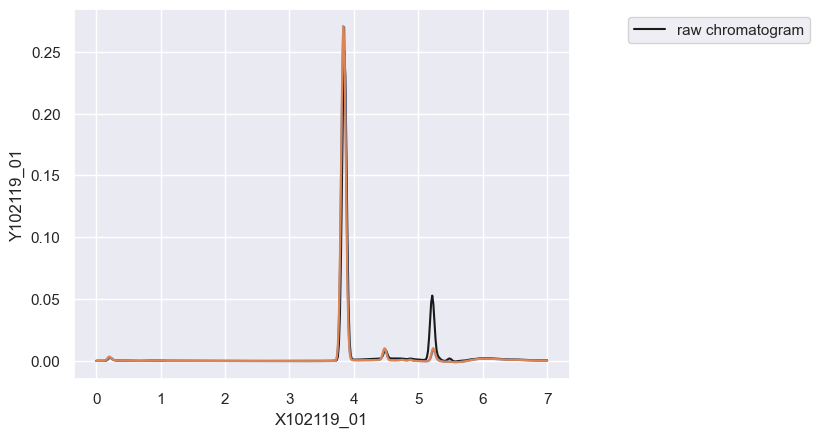

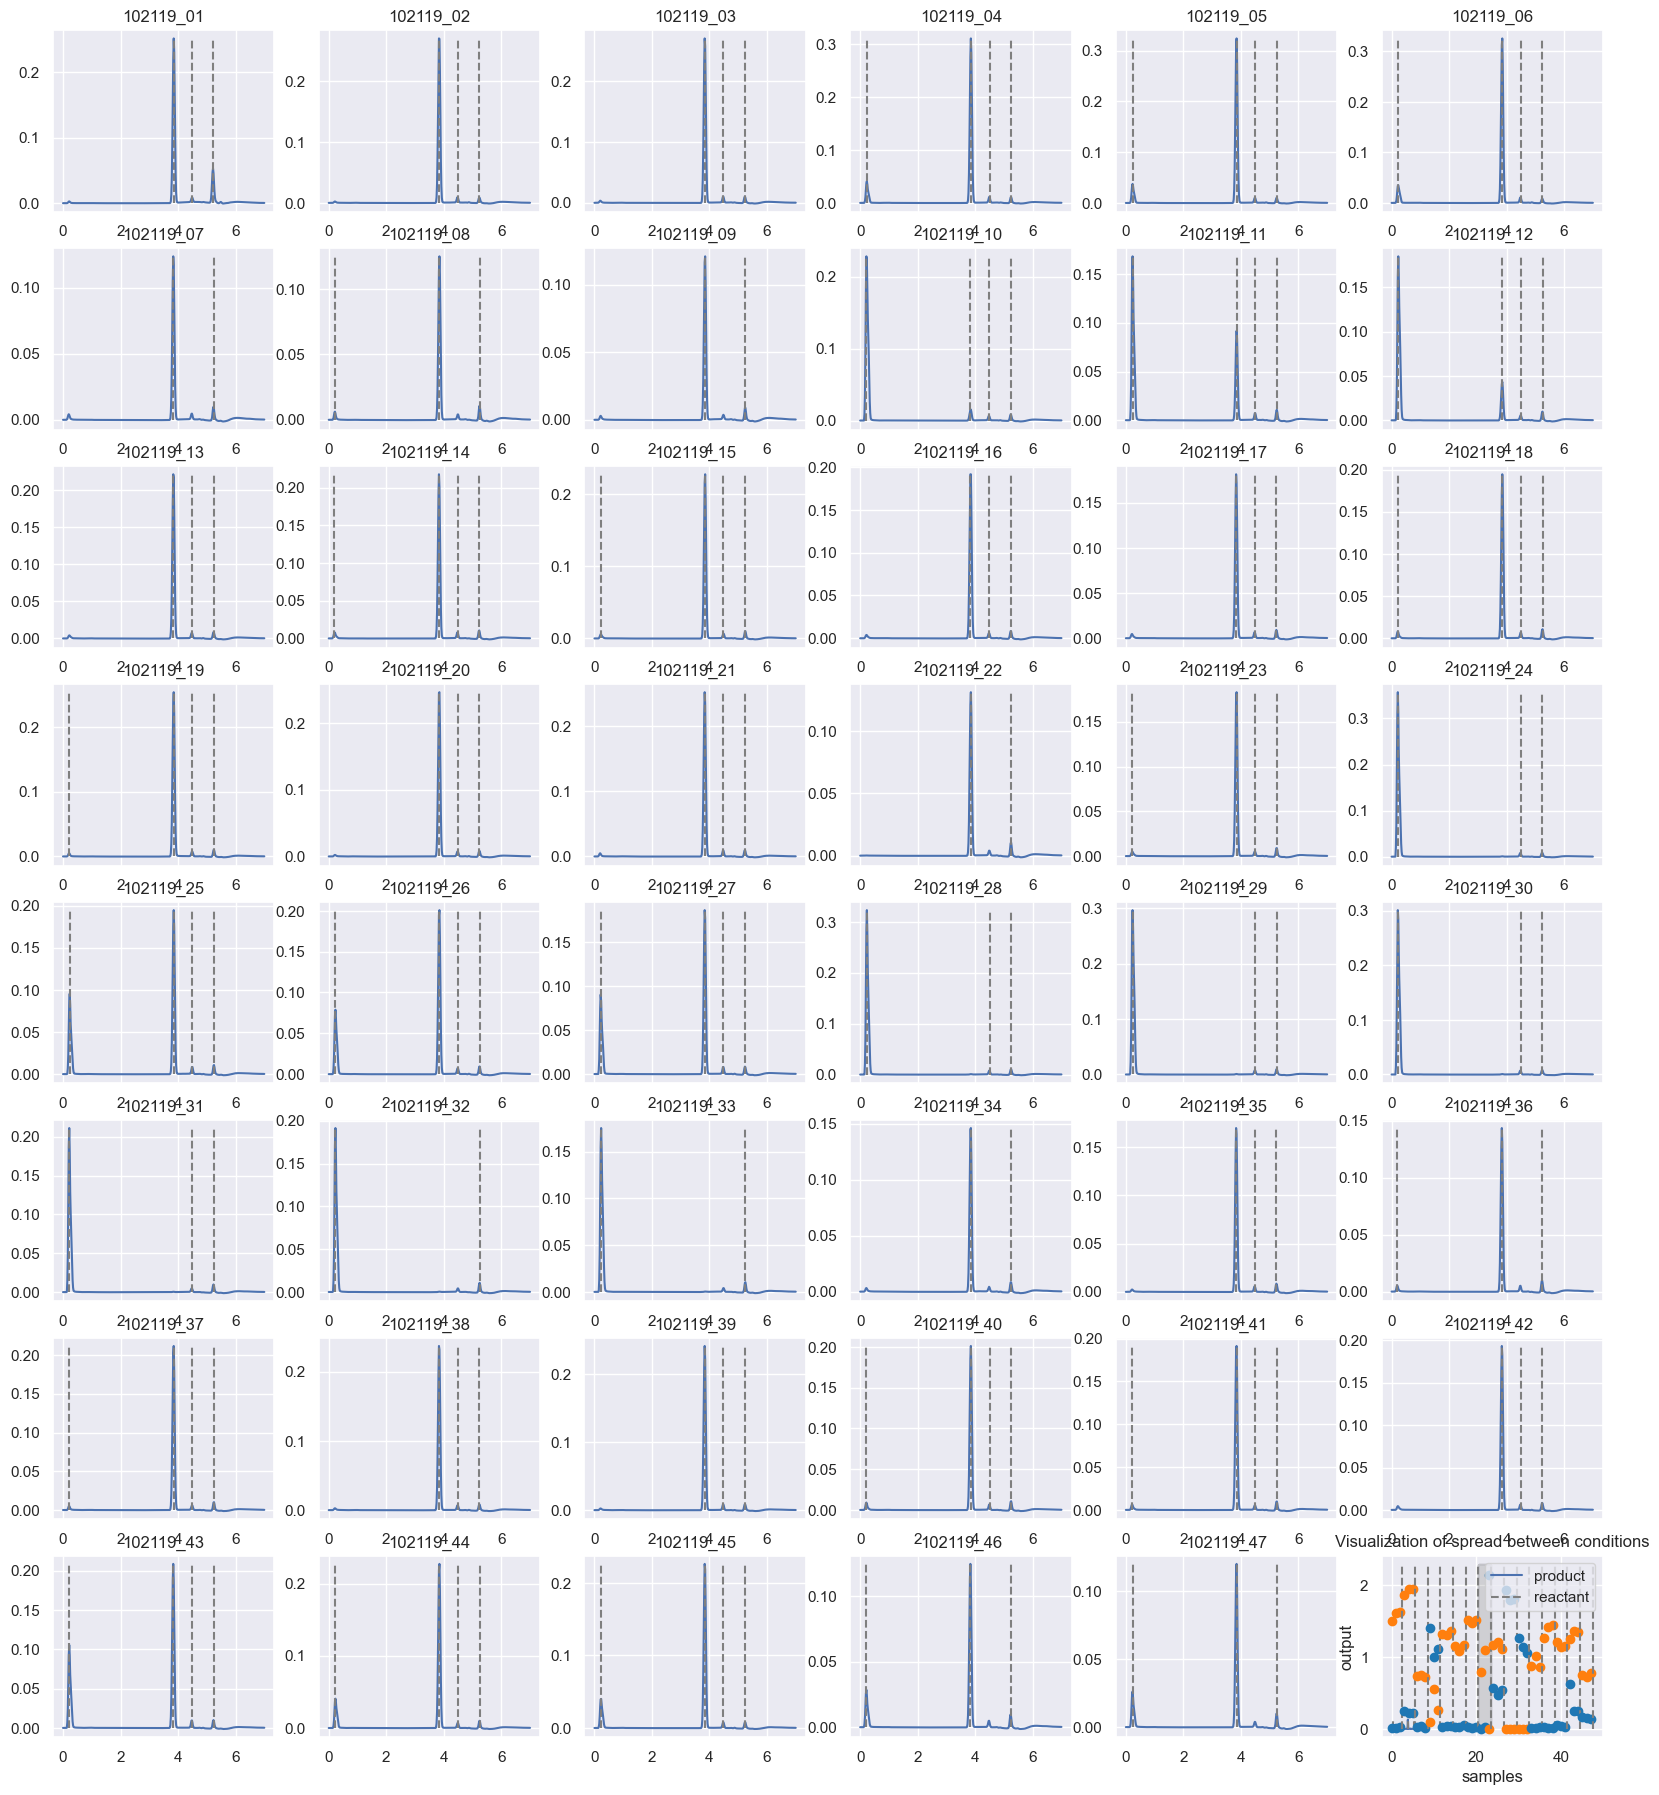

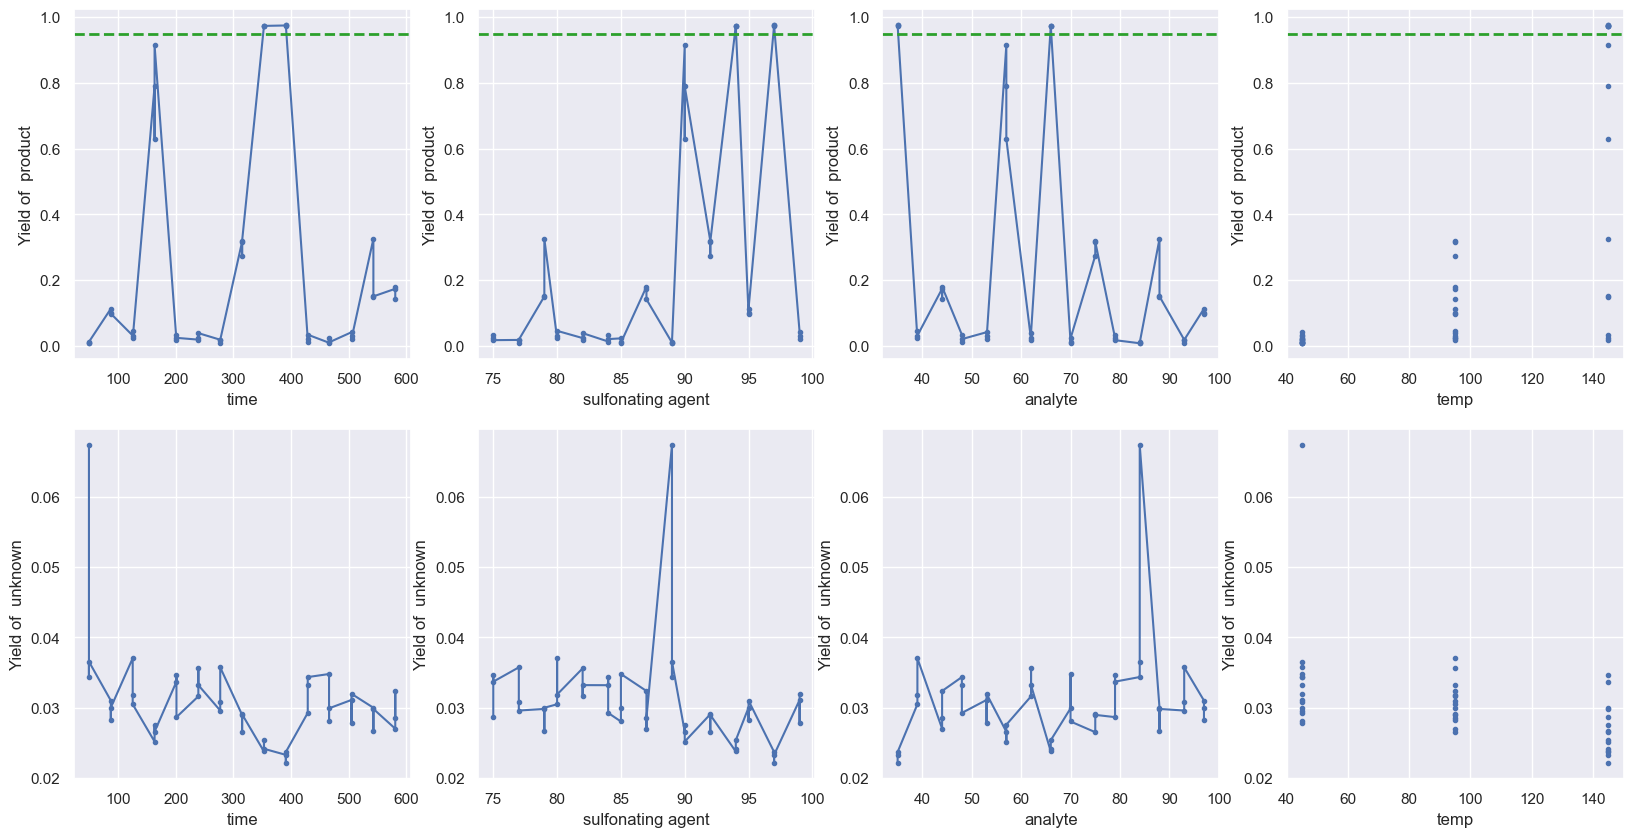

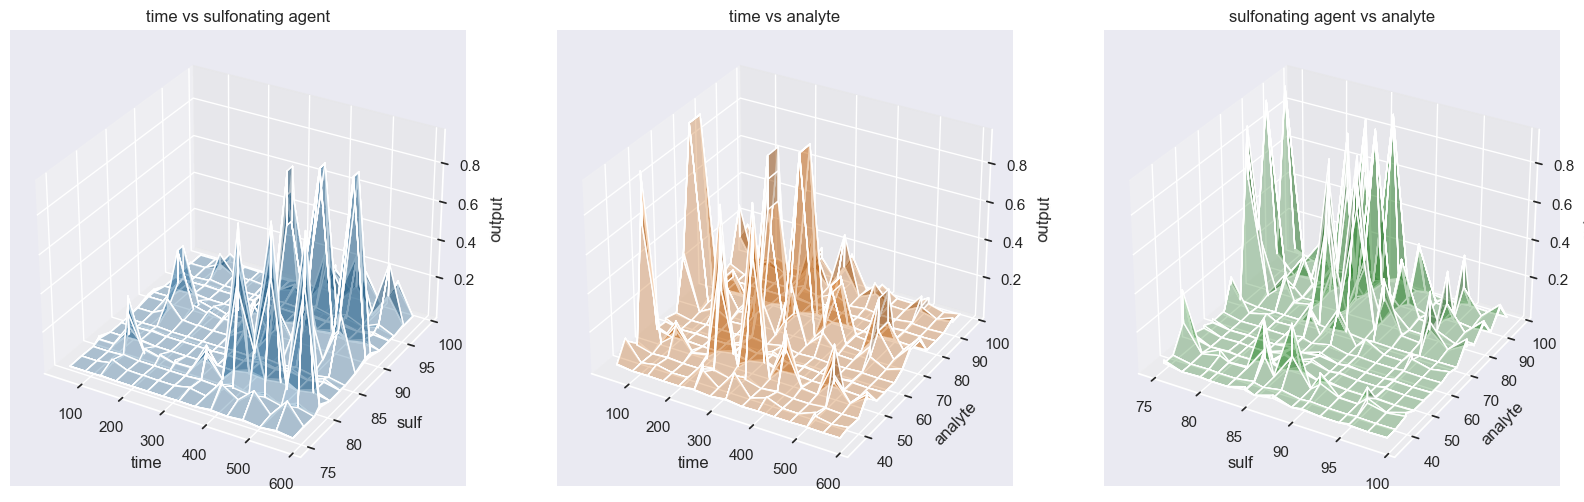

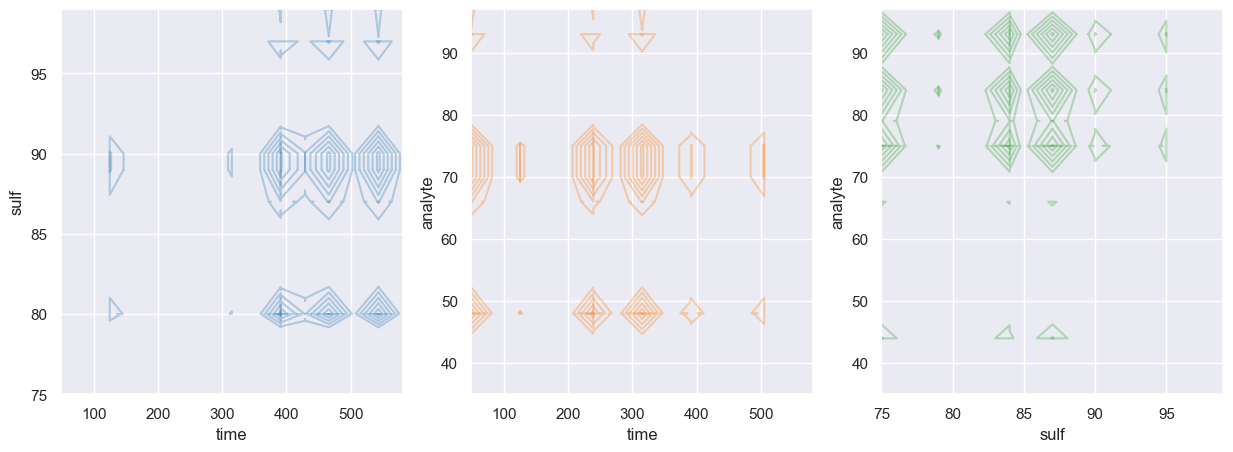

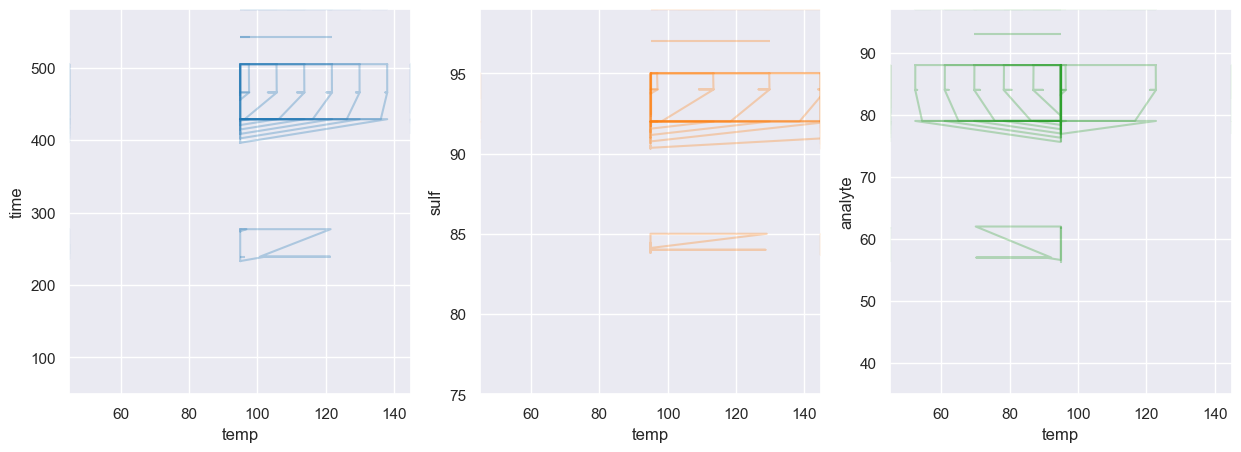

In [4]:
from PNNL_spectra_extract import data_102119

In [5]:
avg_data = data_102119.groupby('time').mean().reset_index()[['time','temp','sulf','analyte','yield product']]
std_data = data_102119.groupby('time').std().reset_index()[['time','temp','sulf','analyte','yield product']]
avg_data

,time,temp,sulf,analyte,yield product
0,49,45.0,89.0,84.0,0.009903
1,87,95.0,95.0,97.0,0.103900
2,125,95.0,80.0,39.0,0.033182
3,163,145.0,90.0,57.0,0.777693
4,201,145.0,75.0,79.0,0.025126
5,239,95.0,82.0,62.0,0.027045
6,277,45.0,77.0,93.0,0.015058
7,315,95.0,92.0,75.0,0.303520
8,353,145.0,94.0,66.0,0.972973
9,391,145.0,97.0,35.0,0.974877


# Prepare data

In [6]:
x1 = torch.tensor([avg_data['time'],avg_data['temp'],avg_data['sulf'],avg_data['analyte']],dtype=torch.float32).T#[:48]
y1 = torch.tensor(avg_data['yield product'],dtype=torch.float32).reshape(-1,1)

# First BO 4D

Using: single task GP, qNegIntegratedPosteriorVariance 

In [7]:
# Set up for BO

# bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device) # original bounds in iteration 1
bounds = torch.tensor([[avg_data['time'].min(),avg_data['temp'].min(),avg_data['sulf'].min() , avg_data['analyte'].min()], [avg_data['time'].max(), avg_data['temp'].max(), avg_data['sulf'].max() , avg_data['analyte'].max()]], dtype=dtype, device=device)

# Set batch size - batch size is three since looking for top 3 most uncertain  
batch_size = 3 


In [8]:
# Training data
train_x = torch.tensor(x1, dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(y1, dtype=dtype)

# Create the surrogate model
# Single task GP
gp_model = SingleTaskGP(train_x, train_y)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

# Mixed Single task GP
mixed_model = MixedSingleTaskGP(train_x, train_y,cat_dims=[1])
mll = ExactMarginalLogLikelihood(mixed_model.likelihood,mixed_model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-05)
    )
  )
  (model): MixedSingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-05)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): AdditiveKernel(
      (kernels): ModuleList(
        (0): ScaleKernel(
          (base_kernel): AdditiveKernel(
            (kernels): ModuleList(
              (0): MaternKernel(
                (raw_lengthscale_constraint): GreaterThan(1.000E-04)
              )
              (1): ScaleKernel(
                (base_kernel): CategoricalKernel(
                  (raw_lengthscale_constraint): GreaterThan(1.000E-06)
                )
                (raw_outputscale_constraint): Positive()
              )
            )
         

In [9]:
# Possible Aquisiton functions to use - All using single task GP

# Parameters for  EI 
best_f = torch.tensor(1 ,dtype=dtype) 
# for qNEGPV
mc_points = x1

# List of aquisition functions
qEI = qExpectedImprovement(model=gp_model, best_f=best_f)
qUCB = qUpperConfidenceBound(model=gp_model, beta=5) #sampler=SobolQMCNormalSampler(num_samples=15) beta = 0.1
qnegPV = qNegIntegratedPosteriorVariance(model=gp_model, mc_points = mc_points)

In [10]:
# set aquisition function
acq_funcs = qnegPV

# Run the BO iteration 
candidate2, _ = optimize_acqf(
    acq_function=acq_funcs,
    bounds=bounds,
    q=batch_size,
    num_restarts=1,
    raw_samples=100,
    options={"dtype": dtype, "device": device}
)

print("Centroids of Temperature Clusters:")
print(candidate2.round())


Centroids of Temperature Clusters:
tensor([[499.,  92.,  88.,  49.],
        [ 72.,  70.,  98.,  42.],
        [297.,  67.,  94.,  88.]])


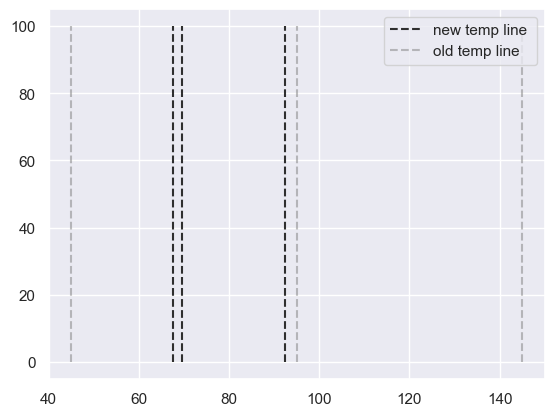

In [11]:
# Plot of new temp lines
old = [45,95,145]
plt.vlines(candidate2[:,1],0,100, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,100, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.legend(['new temp line ','old temp line'])

# Rerun 4D BO using mixed variable

In [12]:
# BO parameters
batch_size = 15

# Define the bounds for continuous variables
bounds = torch.tensor([
    [30.0, 20.0, 75.0, 33.0],  # Lower bounds for the 3 continuous variables
    [600.0, 170.0,100.0, 100.0]   # Upper bounds for the 3 continuous variables
])
# xlimits = np.array([[75.0, 100.0], [33.0, 100.0],[20.0,170.0],[30.0,600.0]])

# Discrete variable choices from 1D BO
discrete_choices= candidate2[:,1].numpy().T
fixed_features_list = [{1: float(discrete_choices[0])},{1: float(discrete_choices[1])},{1: float(discrete_choices[2])}]#[{0: float(choice)} for choice in discrete_choices]
fixed_features_list

[{1: 92.49182891845703}, {1: 69.54081726074219}, {1: 67.4599609375}]

In [13]:
train_x = torch.tensor(x1, dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(y1, dtype=dtype)

# Refit the model with the new data
model = MixedSingleTaskGP(train_x, train_y,cat_dims=[1]) # Cat_dim = 1 since temperature data is in index 1
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-05)
    )
  )
  (model): MixedSingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-05)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): AdditiveKernel(
      (kernels): ModuleList(
        (0): ScaleKernel(
          (base_kernel): AdditiveKernel(
            (kernels): ModuleList(
              (0): MaternKernel(
                (raw_lengthscale_constraint): GreaterThan(1.000E-04)
              )
              (1): ScaleKernel(
                (base_kernel): CategoricalKernel(
                  (raw_lengthscale_constraint): GreaterThan(1.000E-06)
                )
                (raw_outputscale_constraint): Positive()
              )
            )
         

In [14]:
# Set of aquisition functions that can be used for mixed
qEI = qExpectedImprovement(model=model, best_f=best_f)
qUCB = qUpperConfidenceBound(model=model, beta=5) #sampler=SobolQMCNormalSampler(num_samples=15) beta = 0.1
qPV = qNegIntegratedPosteriorVariance(model=model, mc_points = mc_points) # This does not work for mixed... 

In [15]:
# Choose aquisition functions
acq_funcs = qEI

# Re-run the BO for the mixed with constrained temps
candidate1, _ = optimize_acqf_mixed(
    acq_function=acq_funcs,
    bounds=bounds,
    q=batch_size,
    fixed_features_list=fixed_features_list,
    num_restarts=10,
    raw_samples=15,
    options={"dtype": dtype, "device": device}
)


In [16]:
# Summaries the BO into a pandas df 
time = candidate1[:,0]//1
temp = candidate1[:,1]//1
sulf = candidate1[:,2]//1
anly = candidate1[:,3]//1

data = {
    'time': time,
    'temp': temp,
    'sulf': sulf,
    'anly': anly
}
df_candidate1 = pd.DataFrame(data)
df_candidate1.sort_values('temp')

,time,temp,sulf,anly
2,74.0,67.0,98.0,68.0
4,295.0,67.0,78.0,73.0
5,583.0,67.0,83.0,40.0
6,579.0,67.0,86.0,42.0
9,506.0,67.0,96.0,94.0
14,185.0,67.0,85.0,60.0
1,283.0,69.0,79.0,48.0
7,293.0,69.0,87.0,82.0
10,172.0,69.0,89.0,44.0
11,228.0,69.0,83.0,75.0


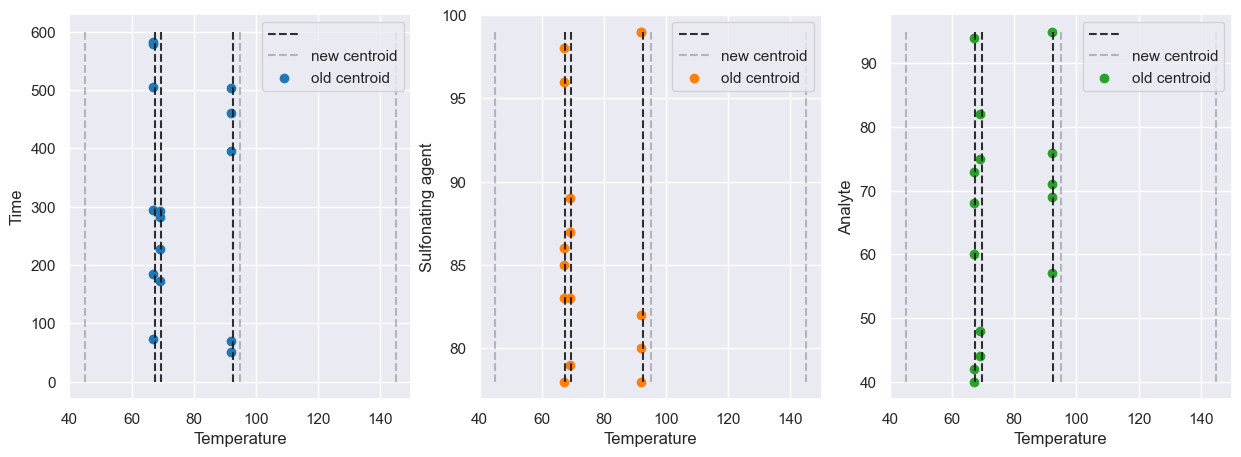

In [17]:
# Plot of the final BO
old = [45,95,145]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.vlines(candidate2[:,1],0,600, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(df_candidate1['temp'],df_candidate1['time'],color = 'tab:blue')
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.legend(['','new centroid','old centroid'])

plt.subplot(1,3,2)
plt.vlines(candidate2[:,1],df_candidate1['sulf'].min(),df_candidate1['sulf'].max(), color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,df_candidate1['sulf'].min(),df_candidate1['sulf'].max(), color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(df_candidate1['temp'],df_candidate1['sulf'],color = 'tab:orange')
plt.xlabel('Temperature')
plt.ylabel('Sulfonating agent')
plt.legend(['','new centroid','old centroid'])

plt.subplot(1,3,3)
plt.vlines(candidate2[:,1],df_candidate1['anly'].min(),df_candidate1['anly'].max(), color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,df_candidate1['anly'].min(),df_candidate1['anly'].max(), color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(df_candidate1['temp'],df_candidate1['anly'],color = 'tab:green')
plt.xlabel('Temperature')
plt.ylabel('Analyte')
plt.legend(['','new centroid','old centroid'])


In [18]:
def contour_all(ax,data_temp,input1,input2,output,color):
    # Grab some test data.
    # X, Y, Z = axes3d.get_test_data(0.05)
    X = data_temp.sort_values(input1)[input1].to_numpy()
    Y = data_temp.sort_values(input2)[input2].to_numpy()
    X, Y = np.meshgrid(X, Y) 
    out1,out2 = data_temp.sort_values(input1)[output].to_numpy(),data_temp.sort_values(input2)[output].to_numpy() #data_temp[output].to_numpy(),data_temp[output].to_numpy()#
    Z = np.matmul(out1.reshape(len(out1),1),out2.reshape(1,len(out2)))
    # Z1,Z2 = np.meshgrid(data_temp.sort_values(input1)[output].to_numpy(), data_temp.sort_values(input2)[output].to_numpy())

    ## Plot outside 
    # fig = plt.figure()
    # ax = fig.add_subplot(projection='3d')
    ## Plot a basic wireframe.
    # ax.plot_wireframe(X, Y, Z1, rstride=10, cstride=0,color='tab:grey')
    ax.contour(X, Y, Z,8,alpha= 0.3,colors=color)
    # ax.contourf(X, Y, Z, 8, alpha=.5) # plt.contourf(X, Y, f(X, Y), 8, alpha=.75, cmap=plt.cm.hot)
    # C = ax.contour(X, Y, Z, 8, colors='black', linewidth=.25,linstlyle = '--') # C = plt.contour(X, Y, f(X,Y), 8, colors='black', linewidth=.5)
    # ax.clabel(C, inline=1, fontsize=1)

    # ax.view_init(elev=20, azim=120) 
    ax.set_xlabel(input1)
    ax.set_ylabel(input2)

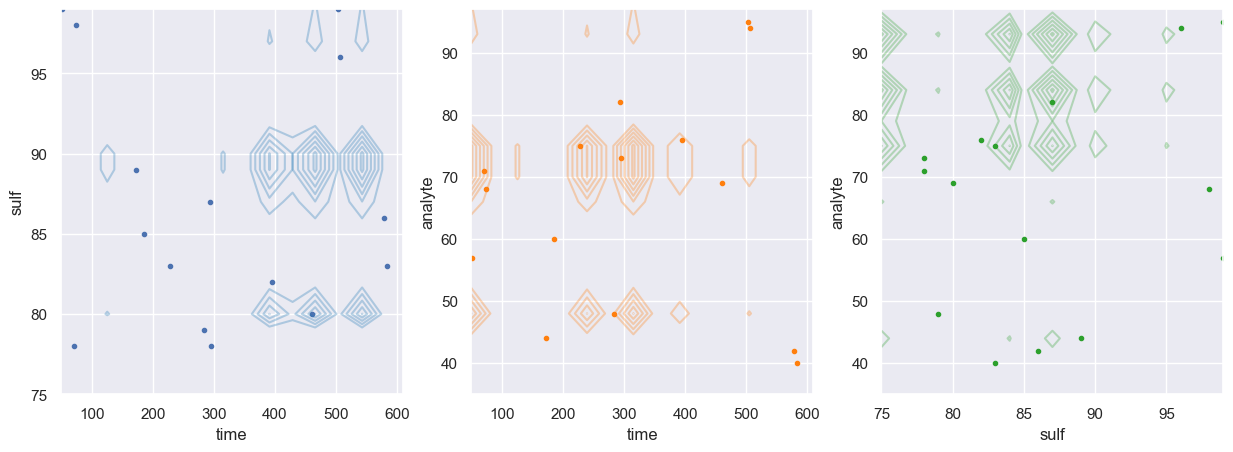

In [19]:
# Plot of the contour plots and the new points
fig,(ax,ax1,ax2) = plt.subplots(1, 3, figsize=(15, 5))

contour_all(ax,avg_data,'time','sulf','yield product','tab:blue')
ax.scatter(df_candidate1['time'],df_candidate1['sulf'],marker='.')

contour_all(ax1,avg_data,'time','analyte','yield product','tab:orange')
ax1.scatter(df_candidate1['time'],df_candidate1['anly'],marker='.',color='tab:orange')

contour_all(ax2,avg_data,'sulf','analyte','yield product','tab:green')
ax2.scatter(df_candidate1['sulf'],df_candidate1['anly'],marker='.',color='tab:green')
